In [1]:
import logging
from datetime import datetime

import numpy as np
import numpy.typing as npt
import pandas as pd
from scipy.special import expit
import seaborn as sns
import os, sys, glob
from datetime import datetime, date
import matplotlib.pyplot as plt
import arviz as az
import matplotlib.dates as mdates
import causalpy as cp


### Data Gneration process

In [2]:
class ZipCodeDataGenerator:
    """Class to generate data for a simulated geo-experiment of orders by zipcode.

    Orders are modeled as a binomial distribution over the zipcode population.
    The order rate is a function of a trend, seasonal components, the zipcode strength
    (unobserved variable) and the campaign effect for the treatment group.
    """

    def __init__(
        self,
        n_zipcodes: int,
        start_date: datetime,
        end_date: datetime,
        freq: str,
        start_campaign: datetime,
        rng: np.random.Generator,
    ) -> None:
        self.n_zipcodes = n_zipcodes
        self.start_date = start_date
        self.end_date = end_date
        self.freq = freq
        self.start_campaign = start_campaign
        self.rng = rng

    def generate_zipcodes_ids(self) -> npt.ArrayLike:
        return np.arange(start=0, stop=self.n_zipcodes, step=1)

    def generate_dates(self) -> npt.ArrayLike:
        return pd.date_range(start=self.start_date, end=self.end_date, freq=self.freq)

    def generate_base_df(
        self, zipcodes: npt.ArrayLike, date_range: npt.ArrayLike
    ) -> pd.DataFrame:
        data_df: pd.DataFrame = pd.merge(
            left=pd.DataFrame(data={"date": date_range}),
            right=pd.DataFrame(data={"zipcode": zipcodes}),
            how="cross",
        )
        data_df["is_campaign"] = data_df["date"] >= self.start_campaign
        return data_df

    def add_seasonality_features(self, data_df: pd.DataFrame) -> pd.DataFrame:
        data_df["is_weekend"] = data_df["date"].dt.weekday > 4
        data_df["is_weekday"] = ~data_df["is_weekend"]
        data_df["norm_trend"] = np.linspace(start=0, stop=1, num=data_df.shape[0])
        return data_df

    def generate_zipcodes_population(
        self, data_df: pd.DataFrame, zipcodes: npt.ArrayLike
    ) -> pd.DataFrame:
        zipcodes_population_map: dict[int, int] = {
            zipcode: int(10_000 * self.rng.gamma(shape=(zipcode % 3) + 1, scale=1))
            for zipcode in zipcodes
        }
        data_df["population"] = data_df["zipcode"].map(zipcodes_population_map)
        return data_df

    def generate_strength_feature(
        self, data_df: pd.DataFrame, zipcodes: npt.ArrayLike
    ) -> pd.DataFrame:
        zipcodes_strength_map: dict[int, int] = {
            zipcode: (zipcode < (self.n_zipcodes // 2)).astype(int)
            for zipcode in zipcodes
        }
        data_df["strength"] = data_df["zipcode"].map(zipcodes_strength_map)
        return data_df

    def generate_variant_tag(
        self, data_df: pd.DataFrame, zipcodes: npt.ArrayLike
    ) -> pd.DataFrame:
        zipcode_variant_map: dict[int, int] = {
            zipcode: (zipcode < (self.n_zipcodes // 3)).astype(int)
            for zipcode in zipcodes
        }
        data_df["variant"] = (
            data_df["zipcode"]
            .map(zipcode_variant_map)
            .map({0: "control", 1: "treatment"})
        )
        mask = data_df["is_campaign"] & (data_df["variant"] == "treatment")
        data_df["is_campaign_treatment"] = mask
        return data_df

    def generate_order_rate(self, data_df: pd.DataFrame) -> pd.DataFrame:

        base_or: dict[int, float] = {
            0: 0.4,
            1: 0.6,
        }  # base conversion rate depends on the strength level
        treatment_effect: float = 7e-2

        data_df["order_rate_true_logit"] = (
            data_df["strength"].map(base_or)
            + (data_df["is_campaign_treatment"] * treatment_effect)
            - 5e-2 * data_df["is_weekday"]
            + 6e-2 * data_df["norm_trend"]
            - 2.3
        )

        data_df["order_rate_true_logit_no_treatment"] = data_df[
            "order_rate_true_logit"
        ] - (data_df["is_campaign_treatment"] * treatment_effect)

        data_df["order_rate_true"] = expit(data_df["order_rate_true_logit"])
        data_df["order_rate_true_no_treatment"] = expit(
            data_df["order_rate_true_logit_no_treatment"]
        )
        return data_df

    def generate_orders(self, data_df: pd.DataFrame) -> pd.DataFrame:
        data_df["orders"] = rng.binomial(
            n=data_df["population"], p=data_df["order_rate_true"]
        )
        data_df["orders_no_treatment"] = rng.binomial(
            n=data_df["population"], p=data_df["order_rate_true_no_treatment"]
        )
        data_df["order_rate"] = data_df["orders"] / data_df["population"]
        data_df["order_rate_no_treatment"] = (
            data_df["orders_no_treatment"] / data_df["population"]
        )
        data_df["expected_orders"] = data_df["population"] * data_df["order_rate_true"]
        return data_df

    def run(self) -> pd.DataFrame:
        zipcodes = self.generate_zipcodes_ids()
        date_range = self.generate_dates()
        data_df = self.generate_base_df(zipcodes=zipcodes, date_range=date_range)
        data_df = self.add_seasonality_features(data_df=data_df)
        data_df = self.generate_zipcodes_population(data_df=data_df, zipcodes=zipcodes)
        data_df = self.generate_strength_feature(data_df=data_df, zipcodes=zipcodes)
        data_df = self.generate_variant_tag(data_df=data_df, zipcodes=zipcodes)
        data_df = self.generate_order_rate(data_df=data_df)
        data_df = self.generate_orders(data_df=data_df)
        return data_df


In [3]:
seed: int = sum(map(ord, "dummy"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
n_zipcodes: int = 60
start_date: datetime = datetime(year=2023, month=1, day=1)
end_date: datetime = datetime(year=2023, month=8, day=31)
freq: str = "D"
start_campaign: datetime = datetime(year=2023, month=6, day=1)

zipcode_data_generator = ZipCodeDataGenerator(
    n_zipcodes=n_zipcodes,
    start_date=start_date,
    end_date=end_date,
    freq=freq,
    start_campaign=start_campaign,
    rng=rng,
)

data_df: pd.DataFrame = zipcode_data_generator.run()

In [4]:
data_df

,date,zipcode,is_campaign,is_weekend,is_weekday,norm_trend,population,strength,variant,is_campaign_treatment,order_rate_true_logit,order_rate_true_logit_no_treatment,order_rate_true,order_rate_true_no_treatment,orders,orders_no_treatment,order_rate,order_rate_no_treatment,expected_orders
0,2023-01-01,0,False,True,False,0.000000,30793,1,treatment,False,-1.700000,-1.700000,0.154465,0.154465,4761,4791,0.154613,0.155587,4756.448908
1,2023-01-01,1,False,True,False,0.000069,14531,1,treatment,False,-1.699996,-1.699996,0.154466,0.154466,2251,2160,0.154910,0.148648,2244.542577
2,2023-01-01,2,False,True,False,0.000137,17821,1,treatment,False,-1.699992,-1.699992,0.154466,0.154466,2780,2736,0.155996,0.153527,2752.744647
3,2023-01-01,3,False,True,False,0.000206,31232,1,treatment,False,-1.699988,-1.699988,0.154467,0.154467,4833,4857,0.154745,0.155514,4824.309522
4,2023-01-01,4,False,True,False,0.000274,24747,1,treatment,False,-1.699984,-1.699984,0.154467,0.154467,3942,3861,0.159292,0.156019,3822.605122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14575,2023-08-31,55,True,False,True,0.999726,6283,0,control,False,-1.890016,-1.890016,0.131243,0.131243,825,831,0.131307,0.132262,824.597208
14576,2023-08-31,56,True,False,True,0.999794,24962,0,control,False,-1.890012,-1.890012,0.131243,0.131243,3290,3270,0.131800,0.130999,3276.089306
14577,2023-08-31,57,True,False,True,0.999863,2619,0,control,False,-1.890008,-1.890008,0.131244,0.131244,359,321,0.137075,0.122566,343.726808
14578,2023-08-31,58,True,False,True,0.999931,9326,0,control,False,-1.890004,-1.890004,0.131244,0.131244,1246,1246,0.133605,0.133605,1223.981546


### Exploratory Data Anaylsis 

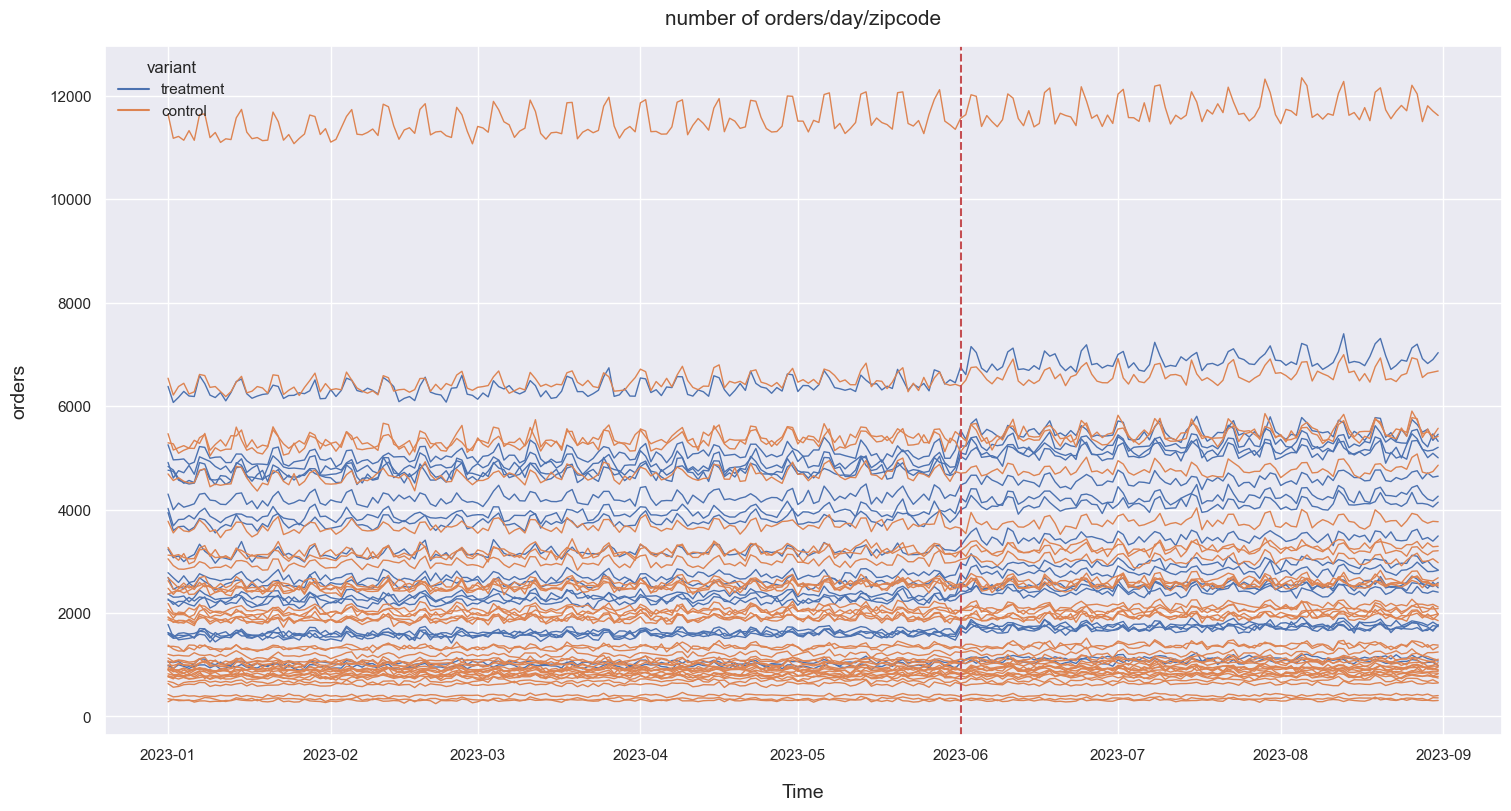

In [5]:
sns.set_theme(style='darkgrid')
plt.figure(figsize=(15,8))

s = sns.lineplot(data=data_df.assign(
        zipcode=lambda x: x["zipcode"].astype("category")
    ), x="date", y='orders', hue="variant", linewidth=1, units='zipcode', estimator=None)
s.set_title('number of orders/day/zipcode', y=1.02, fontsize=15)
s.set_xlabel('Time', fontsize=14, labelpad=15)
s.set_ylabel('orders', fontsize=14, labelpad=15)
plt.axvline(datetime(2023,6, 1), color='r', linewidth=1.5, linestyle='--', label = 'Campaign started')
plt.show()

In [6]:
pd.crosstab(data_df["is_campaign"], data_df["variant"])

variant,control,treatment
is_campaign,,
False,6040,3020
True,3680,1840


In [7]:
data_df.pivot_table(values='orders',
               index='variant',
               aggfunc=[np.mean, np.size],
               margins=True)

,mean,size
,orders,orders
variant,,
control,2174.988580,9720
treatment,3169.588066,4860
All,2506.521742,14580


c:\Users\raviteja.kurva\Anaconda3\envs\pymc_env\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\raviteja.kurva\Anaconda3\envs\pymc_env\Lib\site-packages\seaborn\axisgrid.py:208: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  self._figure.subplots_adjust(right=right)
c:\Users\raviteja.kurva\Anaconda3\envs\pymc_env\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.05, 'Orders Distribution by variant Group')

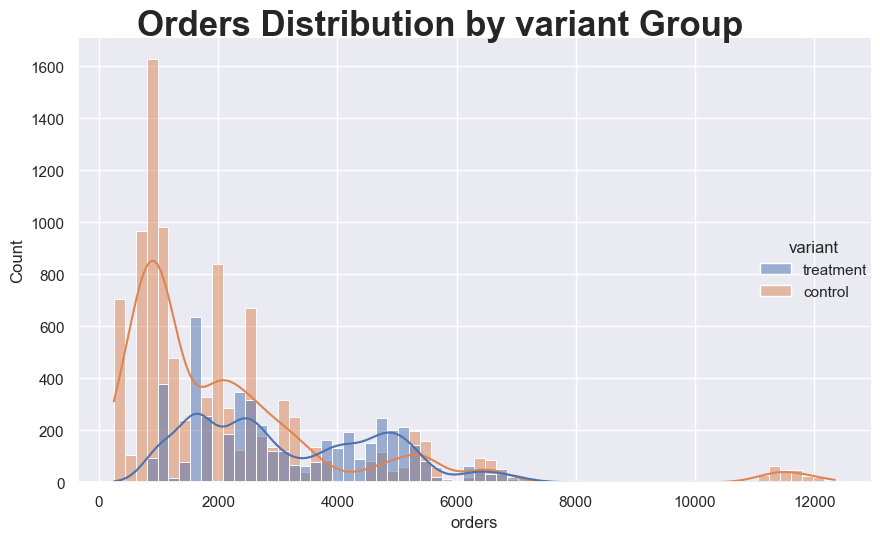

In [8]:
g = sns.displot(
    data=data_df,
    x="orders",
    kind="hist",
    hue="variant",
    kde=True,
    fill=True,
    height=5,
    aspect=1.5,
)
g.fig.suptitle(
    "Orders Distribution by variant Group", y=1.05, fontsize=25, fontweight="bold"
)

c:\Users\raviteja.kurva\Anaconda3\envs\pymc_env\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\raviteja.kurva\Anaconda3\envs\pymc_env\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.05, 'Sales Distribution')

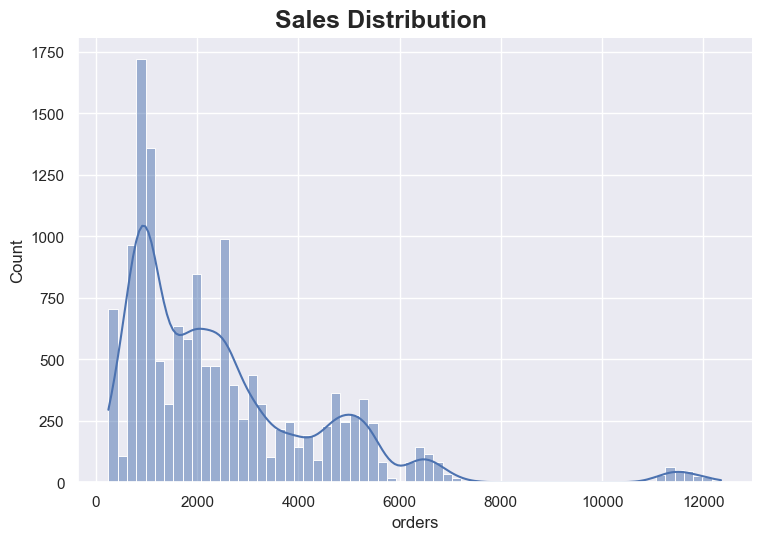

In [9]:
g = sns.displot(
    data=data_df, x="orders", kind="hist", kde=True, fill=True, height=5, aspect=1.5
)
g.fig.suptitle("Sales Distribution", y=1.05, fontsize=18, fontweight="bold")

#### Difference in differences: This is appropriate when you have a pre and post intervention measurement and have a treament and a control group.

#### Difference in Difference from Descriptive Analytics

In [12]:
data_df['post_treatment'] = (data_df['date']>='2023-06-01').astype(int)

In [13]:
data_df

,date,zipcode,is_campaign,is_weekend,is_weekday,norm_trend,population,strength,variant,is_campaign_treatment,order_rate_true_logit,order_rate_true_logit_no_treatment,order_rate_true,order_rate_true_no_treatment,orders,orders_no_treatment,order_rate,order_rate_no_treatment,expected_orders,post_treatment
0,2023-01-01,0,False,True,False,0.000000,30793,1,treatment,False,-1.700000,-1.700000,0.154465,0.154465,4761,4791,0.154613,0.155587,4756.448908,0
1,2023-01-01,1,False,True,False,0.000069,14531,1,treatment,False,-1.699996,-1.699996,0.154466,0.154466,2251,2160,0.154910,0.148648,2244.542577,0
2,2023-01-01,2,False,True,False,0.000137,17821,1,treatment,False,-1.699992,-1.699992,0.154466,0.154466,2780,2736,0.155996,0.153527,2752.744647,0
3,2023-01-01,3,False,True,False,0.000206,31232,1,treatment,False,-1.699988,-1.699988,0.154467,0.154467,4833,4857,0.154745,0.155514,4824.309522,0
4,2023-01-01,4,False,True,False,0.000274,24747,1,treatment,False,-1.699984,-1.699984,0.154467,0.154467,3942,3861,0.159292,0.156019,3822.605122,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14575,2023-08-31,55,True,False,True,0.999726,6283,0,control,False,-1.890016,-1.890016,0.131243,0.131243,825,831,0.131307,0.132262,824.597208,1
14576,2023-08-31,56,True,False,True,0.999794,24962,0,control,False,-1.890012,-1.890012,0.131243,0.131243,3290,3270,0.131800,0.130999,3276.089306,1
14577,2023-08-31,57,True,False,True,0.999863,2619,0,control,False,-1.890008,-1.890008,0.131244,0.131244,359,321,0.137075,0.122566,343.726808,1
14578,2023-08-31,58,True,False,True,0.999931,9326,0,control,False,-1.890004,-1.890004,0.131244,0.131244,1246,1246,0.133605,0.133605,1223.981546,1


compare the oders from treatment to that of control group in the post intervention period.

In [14]:
treatgroup_postinter = data_df.loc[(data_df['variant'] == 'treatment') & (data_df['post_treatment'] == True)]["orders"].mean()
controlgroup_postinter = data_df.loc[(data_df['variant'] == 'control') & (data_df['post_treatment'] == True)]["orders"].mean()

treatgroup_postinter - controlgroup_postinter

1128.169293478261

This estimator is telling us that the campaign is detrimental and that orders will increase by 1128.

compare the orders in the treatment group before and after intervention

In [15]:
treatgroup_before = data_df.loc[(data_df['variant'] == 'treatment') & (data_df['post_treatment'] == False)]["orders"].mean()
treatgroup_after = data_df.loc[(data_df['variant'] == 'treatment') & (data_df['post_treatment'] == True)]["orders"].mean()

treatgroup_after - treatgroup_before

269.8914159228334

This estimator is telling us that we should expect orders to increase by 270 after the intervention. But can we trust this?

In [16]:
controlgroup_preinter = data_df.loc[(data_df['variant'] == 'control') & (data_df['post_treatment'] == False)]["orders"].mean()

diff_in_diff = (treatgroup_after - treatgroup_before)-(controlgroup_postinter-controlgroup_preinter)
diff_in_diff

214.9500881802478

Diff-in-Diff is telling us that we should expect orders to increase by 215 per zipcode. Notice that the assumption that diff-in-diff makes is much more plausible than the other

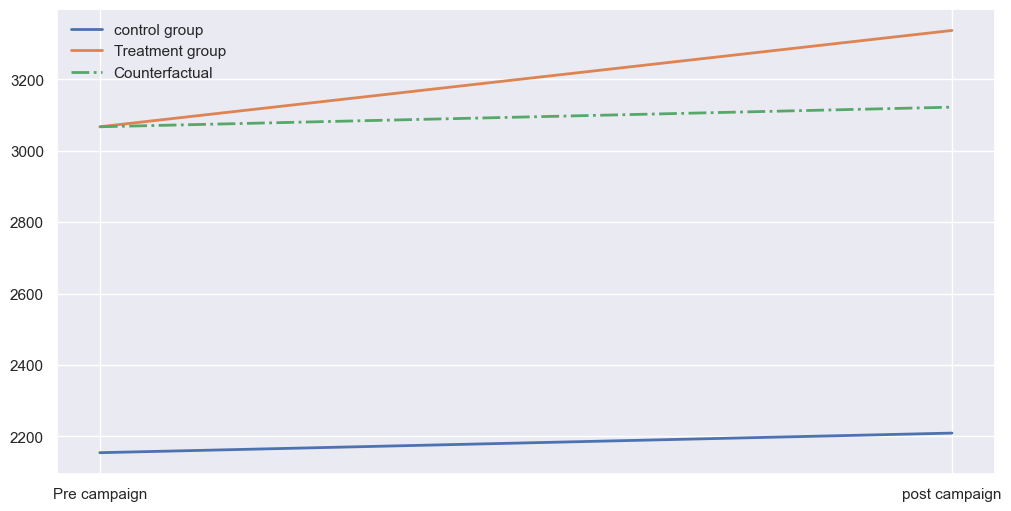

In [17]:
plt.figure(figsize=(10,5))
plt.plot(["Pre campaign", "post campaign"], [controlgroup_preinter, controlgroup_postinter], label="control group", lw=2)
plt.plot(["Pre campaign", "post campaign"], [treatgroup_before, treatgroup_after], label="Treatment group", lw=2)

plt.plot(["Pre campaign", "post campaign"], [treatgroup_before, treatgroup_before+(controlgroup_postinter-controlgroup_preinter)],
         label="Counterfactual", lw=2, color="C2", ls="-.")

plt.legend();

In [18]:
%load_ext autoreload
%autoreload 2
# %config InlineBackend.figure_format = 'svg'
seed = 42

In [19]:
data_df['unit'] = data_df['zipcode']

In [20]:
agg_data_df = (
    data_df
    .groupby(["date", "is_campaign", "variant"], as_index=False)
    .agg({"orders": np.sum})
)

In [21]:
# Define a function to assign unique integers to each datetime within each zipcode
def assign_time_feature(group):
    group['time'] = range(1, len(group) + 1)
    return group

data_df = data_df.groupby('zipcode').apply(assign_time_feature).reset_index(drop=True)

In [22]:
from sklearn.preprocessing import StandardScaler

scaler_control = StandardScaler()
scaler_control.fit(X=data_df['orders'].to_numpy()[..., None])
data_df['orders_scaled'] = scaler_control.transform(
    X=data_df['orders'].to_numpy()[..., None]
).flatten()

### Diff-in-Diff with OLS

In [24]:
import statsmodels.formula.api as smf

did_ols = smf.ols(
    'orders ~ strength*post_treatment', data=data_df
).fit().params["strength:post_treatment"]


print('treatment effect by OLS method:', did_ols)

treatment effect by OLS method: 169.28692292926212


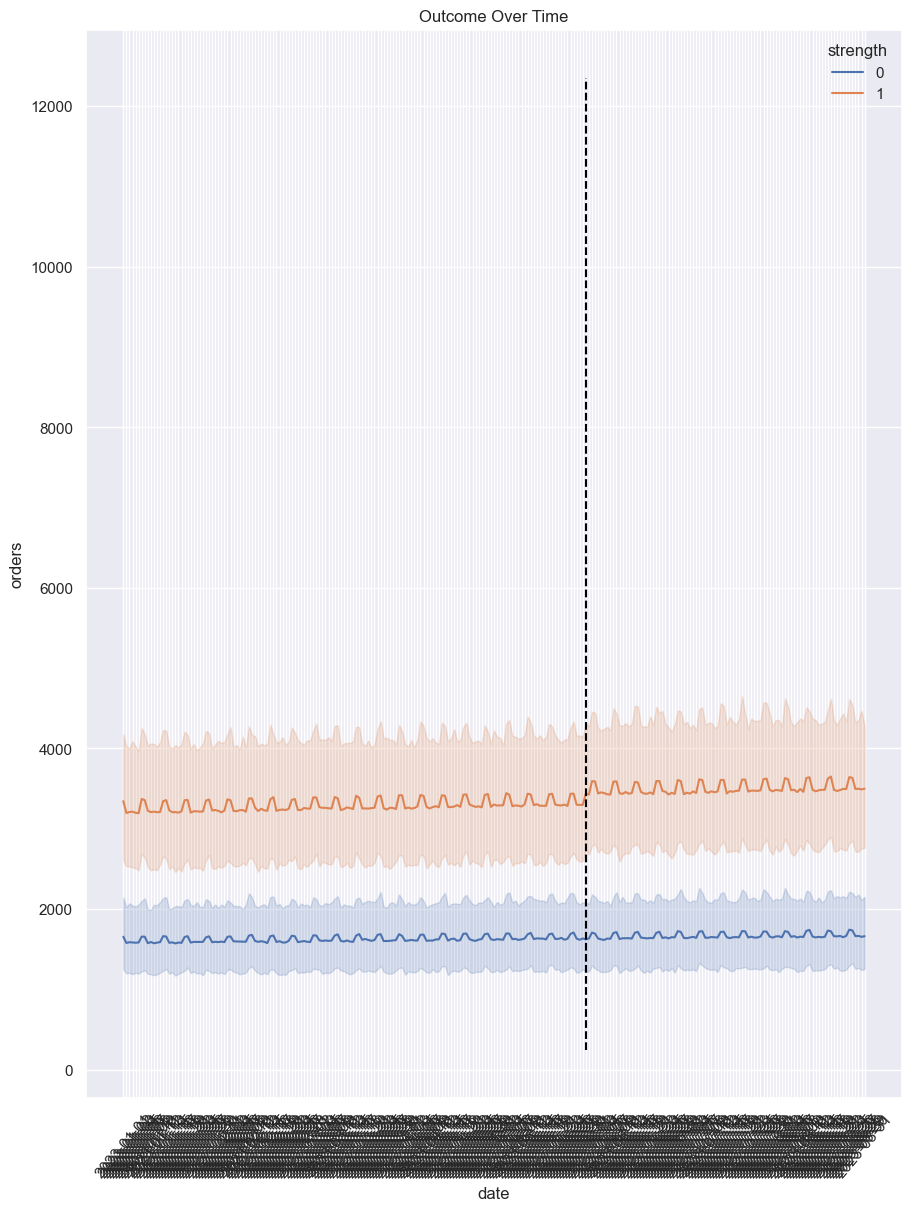

In [27]:
import matplotlib.ticker as plticker


fig, ax = plt.subplots(figsize=(9, 12), sharex=True)


sns.lineplot(data=data_df.astype({"date":"str"}),
             x="date", y="orders", hue="strength", ax=ax)

loc = plticker.MultipleLocator(base=2.0)
# ax2.xaxis.set_major_locator(loc)
ax.vlines("2023-06-01", data_df["orders"].min(), data_df["orders"].max(), color="black", ls="dashed", label="Interv.")
ax.set_title("Outcome Over Time")

plt.xticks(rotation = 50);

In [30]:
m = smf.ols('orders ~ strength:post_treatment + C(zipcode) + C(date)',
            data=data_df).fit()

m.params["strength:post_treatment"]

169.2869229292151

In [31]:
m = smf.ols(
    'orders ~ strength:post_treatment + C(zipcode) + C(date)', data=data_df
).fit(cov_type='cluster', cov_kwds={'groups': data_df['zipcode']})

print("ATT:", m.params["strength:post_treatment"])
m.conf_int().loc["strength:post_treatment"]

ATT: 169.2869229292151


0    116.233092
1    222.340754
Name: strength:post_treatment, dtype: float64

### Bayesian modeling

#### Modeling without the time variable

In [37]:
result = cp.pymc_experiments.DifferenceInDifferences(
    data_df,
    formula="orders ~ 1 + strength*post_treatment",
    time_variable_name="post_treatment",
    group_variable_name="strength",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


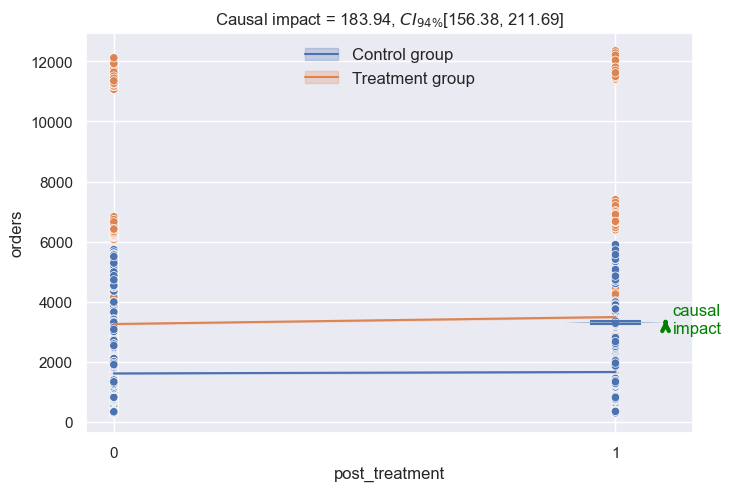

In [42]:
fig, ax = result.plot()

In [44]:
result._plot_causal_impact_arrow(ax)

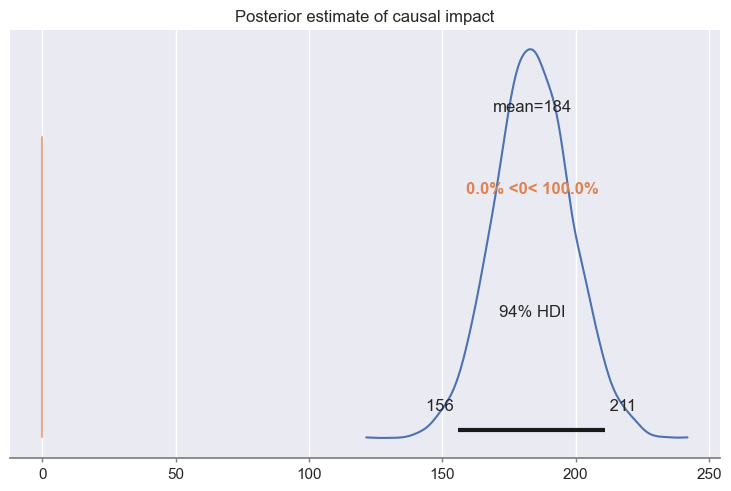

In [39]:
ax = az.plot_posterior(result.causal_impact, ref_val=0, round_to=2)
ax.set(title="Posterior estimate of causal impact");

In [40]:
result.summary()

===========================Difference in Differences============================
Formula: orders ~ 1 + strength*post_treatment

Results:
Causal impact = 183.94, $CI_{94\%}$[156.38, 211.69]
Model coefficients:
Intercept                     1622.07, 94% HDI [1609.40, 1634.59]
strength                      1643.66, 94% HDI [1626.56, 1660.93]
post_treatment                48.73, 94% HDI [28.90, 68.02]
strength:post_treatment       183.94, 94% HDI [156.38, 211.69]
sigma                         458.71, 94% HDI [457.77, 459.66]


#### Analysis 2 - DiD with time variable pre/post observations

In [46]:
result2 = cp.pymc_experiments.DifferenceInDifferences(
    data_df,
    formula="orders ~ 1 + time + strength*post_treatment",
    time_variable_name="time",
    group_variable_name="strength",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


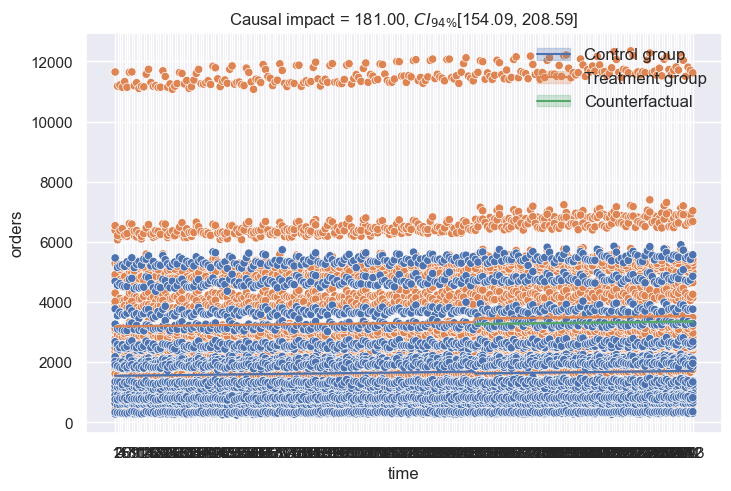

In [47]:
fig, ax = result2.plot();

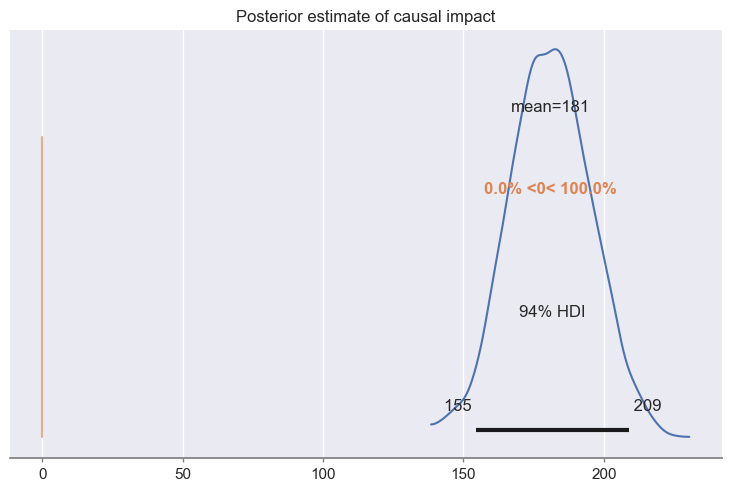

In [48]:
ax = az.plot_posterior(result2.causal_impact, ref_val=0, round_to=3)
ax.set(title="Posterior estimate of causal impact");

In [49]:
result2.summary()

===========================Difference in Differences============================
Formula: orders ~ 1 + time + strength*post_treatment

Results:
Causal impact = 181.00, $CI_{94\%}$[154.09, 208.59]
Model coefficients:
Intercept                     1550.81, 94% HDI [1532.14, 1569.21]
time                          0.93, 94% HDI [0.75, 1.12]
strength                      1644.07, 94% HDI [1627.02, 1661.11]
post_treatment                -61.40, 94% HDI [-90.43, -31.37]
strength:post_treatment       181.00, 94% HDI [154.09, 208.59]
sigma                         458.70, 94% HDI [457.79, 459.65]


From the above two analysis, the results are almost same with **Average Effect of the campaign is 185 orders** increase in sales per zipcode which is quite good effect with **uncertainity range from 160 to 210**